In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

# Impor Data

In [2]:
np.random.seed(7)

In [3]:
data = pd.read_excel("D:/IPB/Skripsi/Data/Prediksi GARCH/Python/garch11_predicted_python.xlsx")
data = data.loc[:, ['Tanggal','Residual']]
data = data.iloc[:914].reset_index(drop=True)
print(data.head())
print(data.shape)

     Tanggal      Residual
0 2021-07-01 -3.637979e-11
1 2021-07-02 -4.950924e+01
2 2021-07-03  9.760829e+01
3 2021-07-04 -1.578354e+02
4 2021-07-05  2.491483e+02
(914, 2)


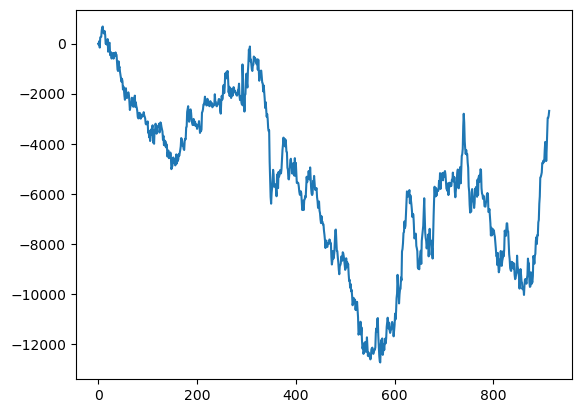

In [4]:
plt.plot(data['Residual'])

### Normalisasi Data

Proses normalisasi data dilakukan menggunakan metode _min-max normalization_ hingga menghasilkan data yang bersakala [0,1].

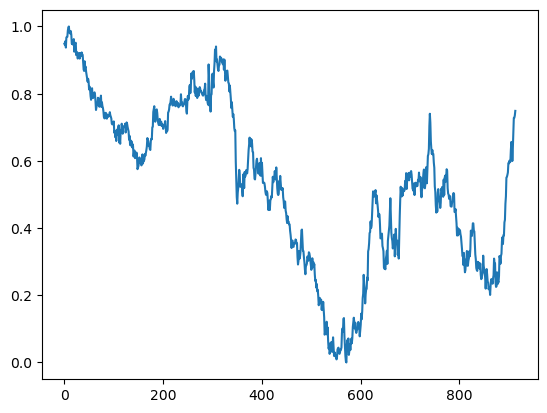

In [5]:
# Step 1: Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data['Residual_normalized'] = scaler.fit_transform(data['Residual'].values.reshape(-1, 1))
plt.plot(data['Residual_normalized'])

# Hyperparameter Tuning

_Hyperparameter tuning_ dilakukan untuk menentukan _hyperparameter_ terbaik melalui langkah validasi berupa _time series k-fold cross validation_. Banyaknya _fold_ yang digunakan dalam langkah validasi adalah sebanyak 5.

### Skenario 1

C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


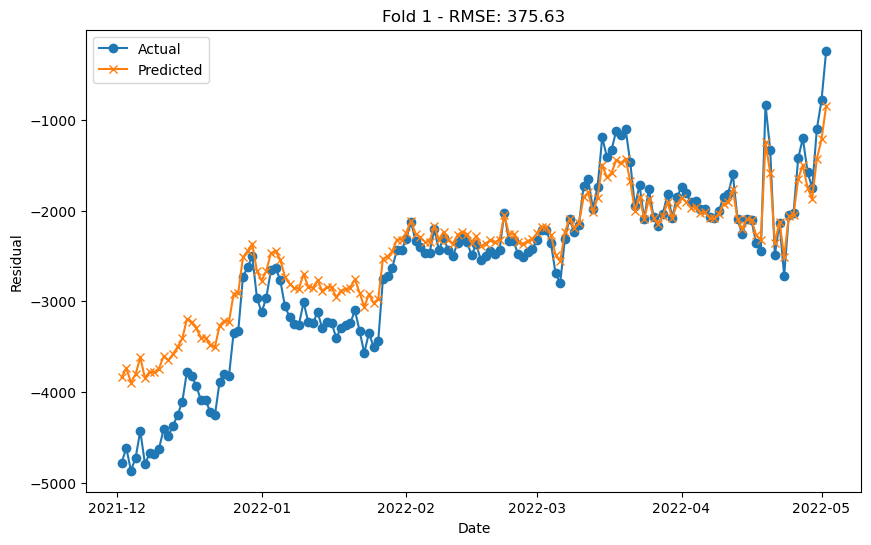

Fold 1 - RMSE: 375.63


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


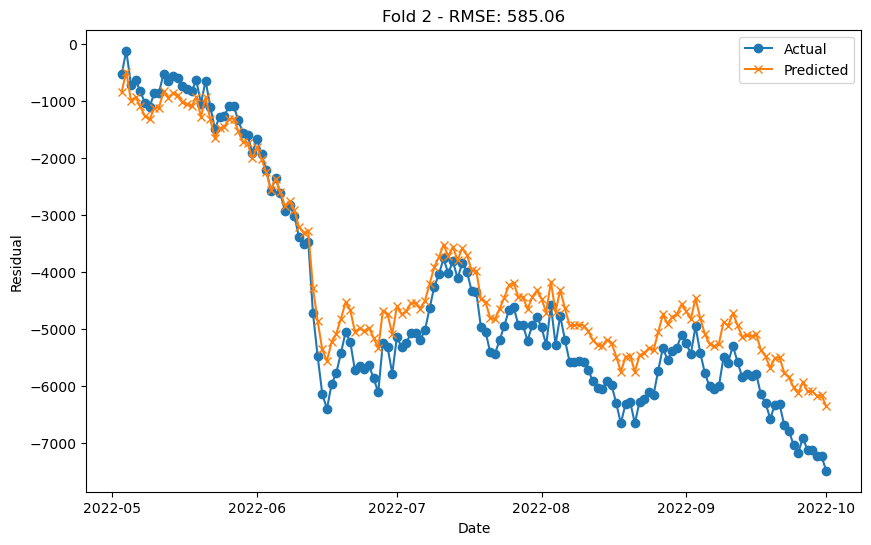

Fold 2 - RMSE: 585.06


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F772D75C60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


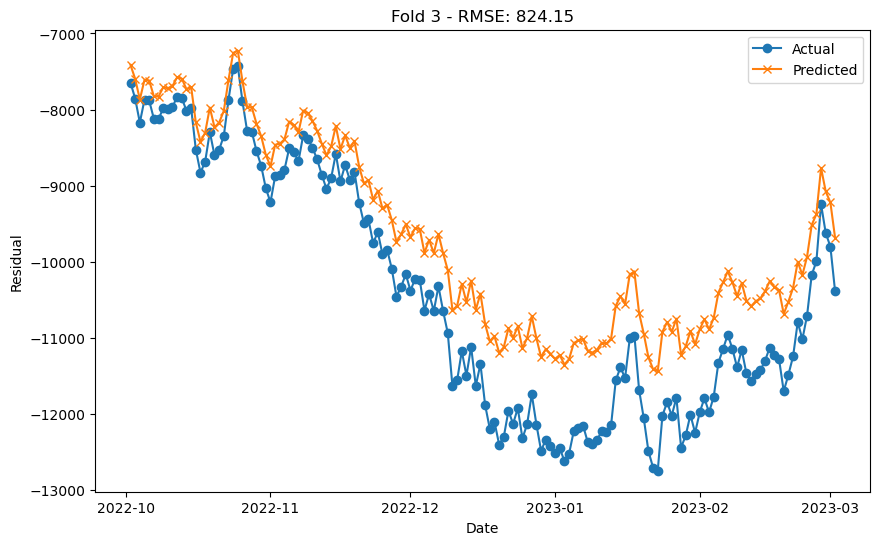

Fold 3 - RMSE: 824.15


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


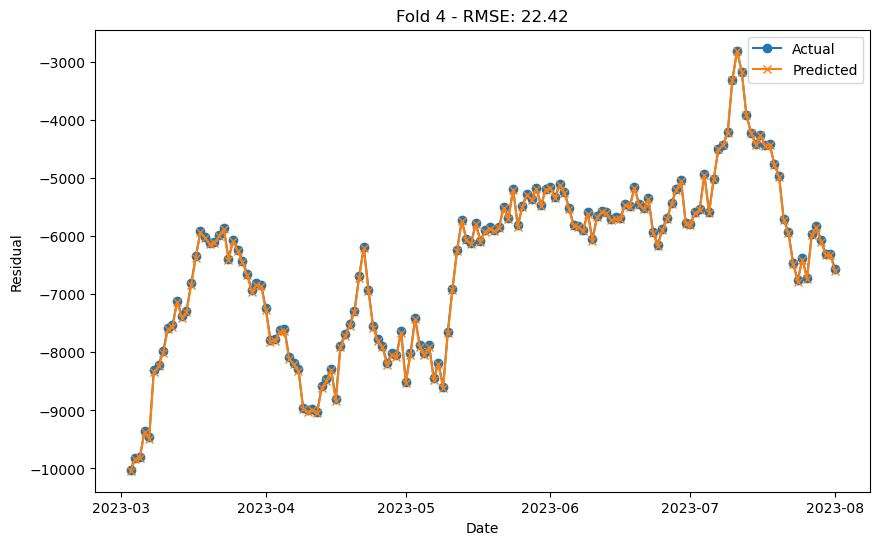

Fold 4 - RMSE: 22.42


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


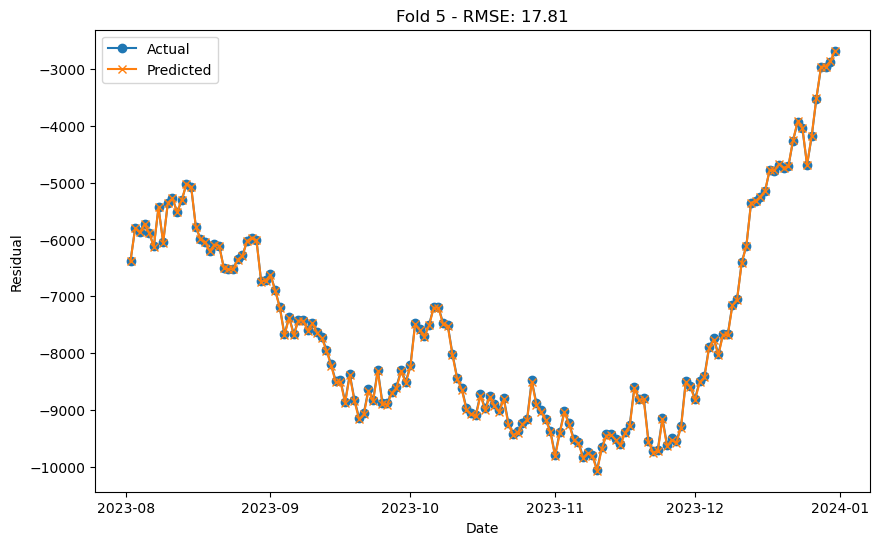

Fold 5 - RMSE: 17.81


In [6]:
#LEARNING RATE: 0,001 dan BATCH SIZE: 16

from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

# Define hyperparameters
learning_rate = 0.001
batch_size = 16
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['Residual_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['Residual_normalized'].values.reshape(-1, 1),
              train_data['Residual_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['Residual_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['Residual'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Tanggal'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Tanggal'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

### Skenario 2

C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


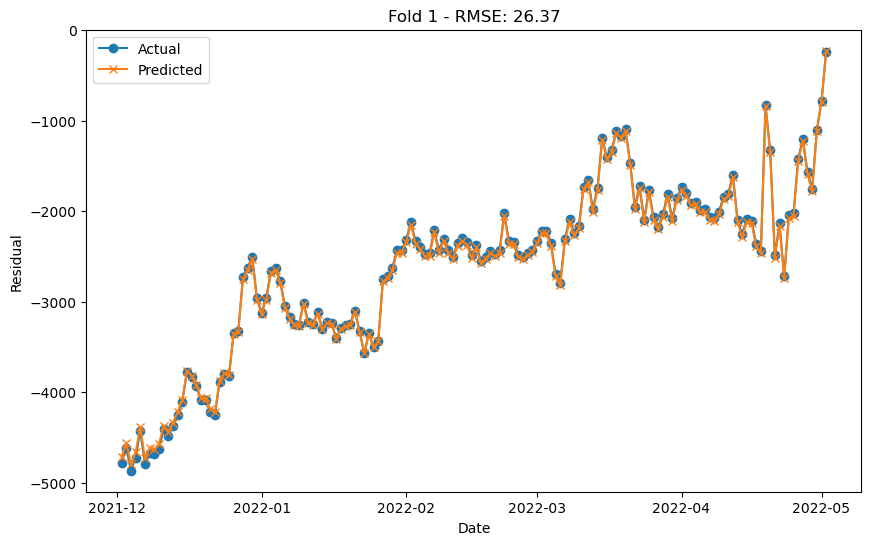

Fold 1 - RMSE: 26.37


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


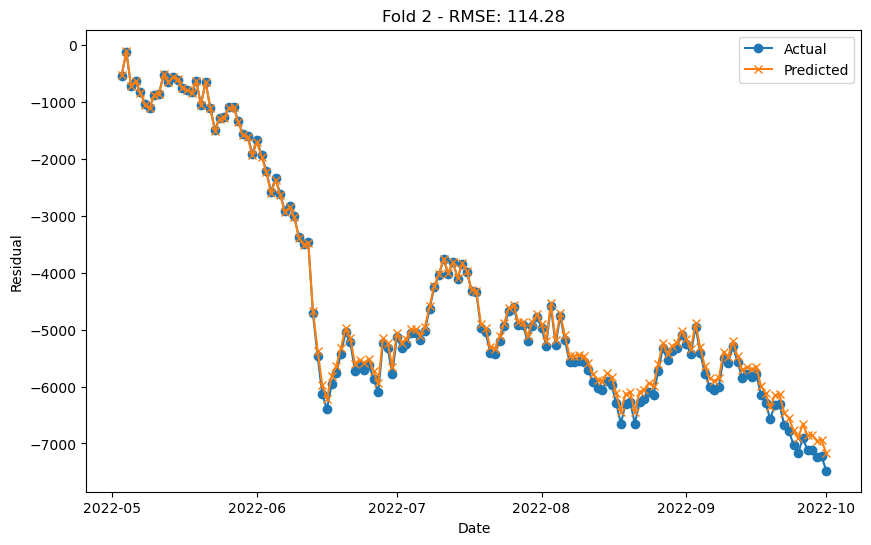

Fold 2 - RMSE: 114.28


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


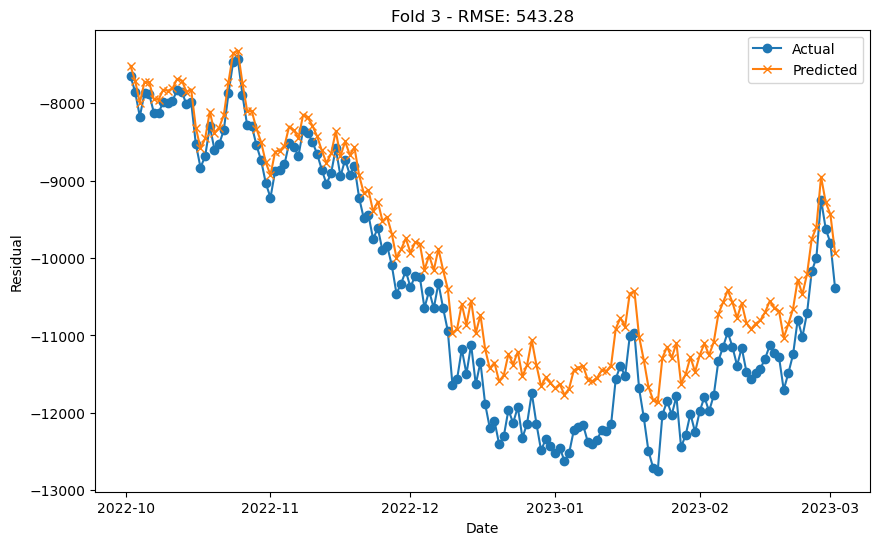

Fold 3 - RMSE: 543.28


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


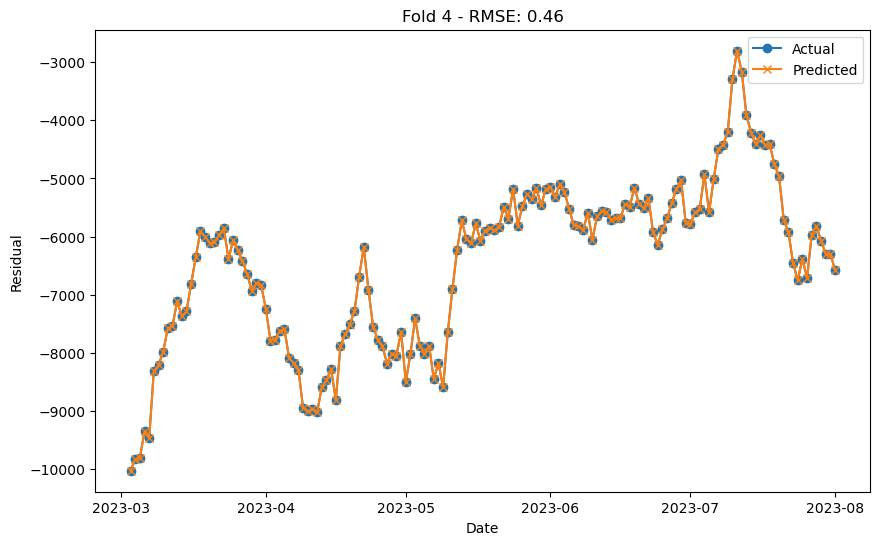

Fold 4 - RMSE: 0.46


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


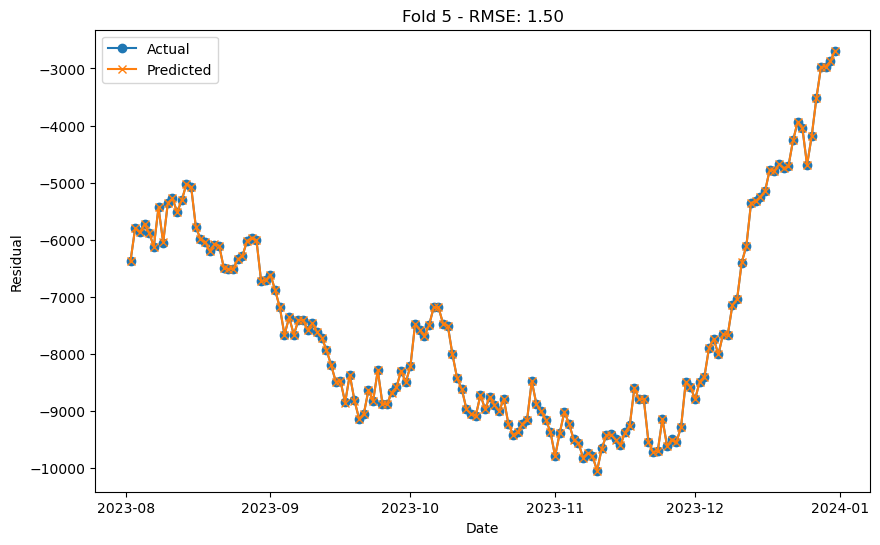

Fold 5 - RMSE: 1.50


In [7]:
#LEARNING RATE: 0,005 dan BATCH SIZE: 16

from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

# Define hyperparameters
learning_rate = 0.005
batch_size = 16
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['Residual_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['Residual_normalized'].values.reshape(-1, 1),
              train_data['Residual_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['Residual_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['Residual'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Tanggal'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Tanggal'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

### Skenario 3

C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


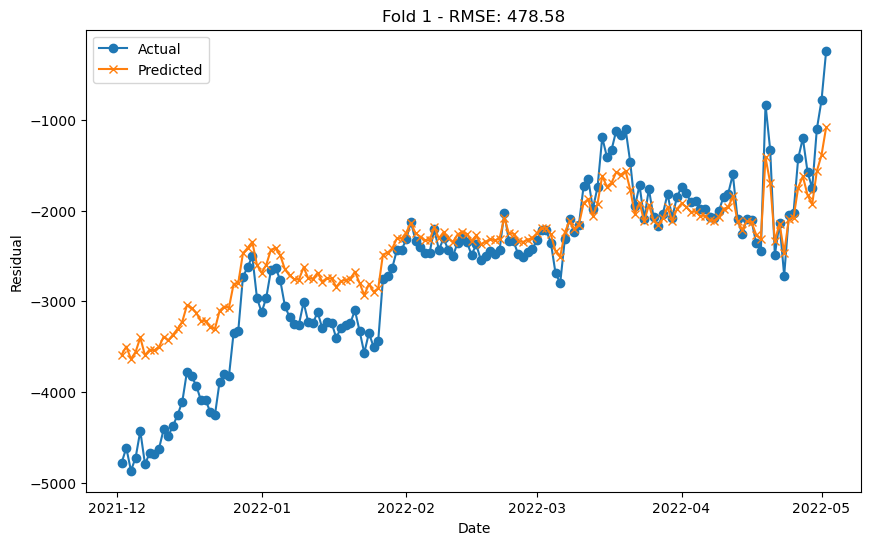

Fold 1 - RMSE: 478.58


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


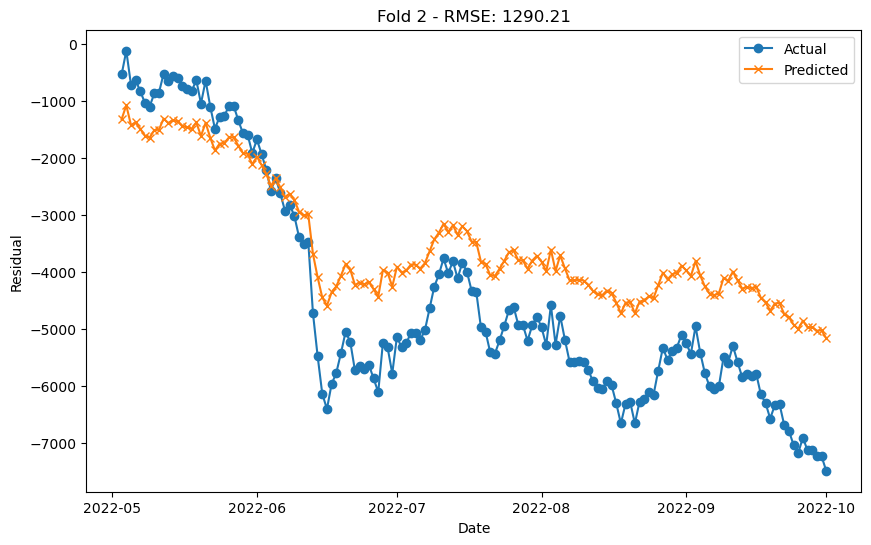

Fold 2 - RMSE: 1290.21


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


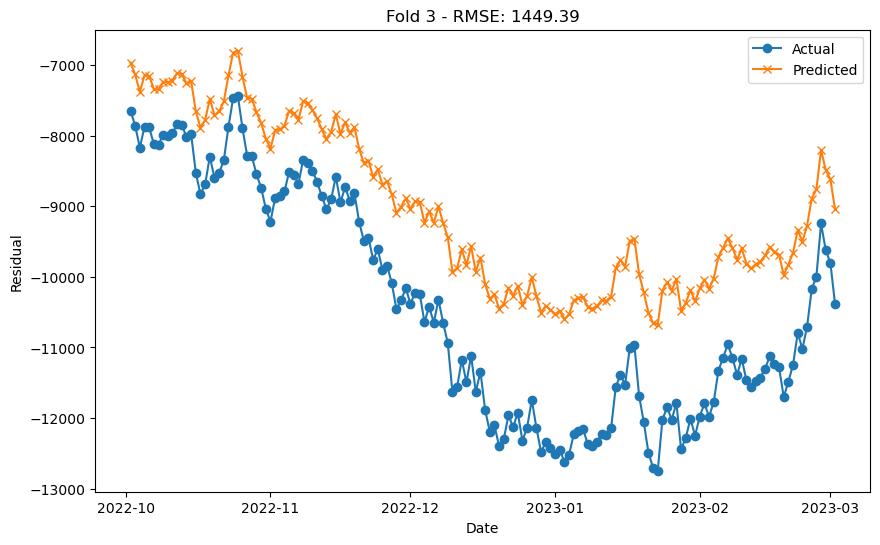

Fold 3 - RMSE: 1449.39


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


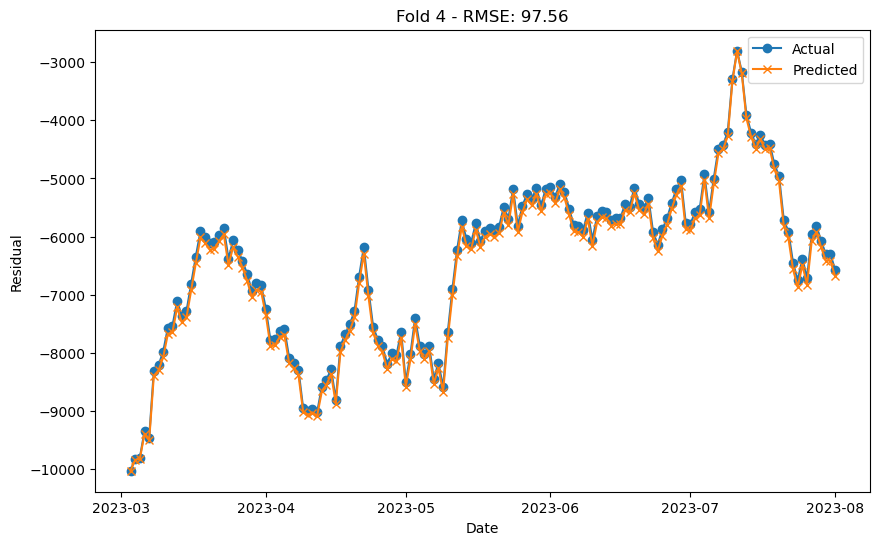

Fold 4 - RMSE: 97.56


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


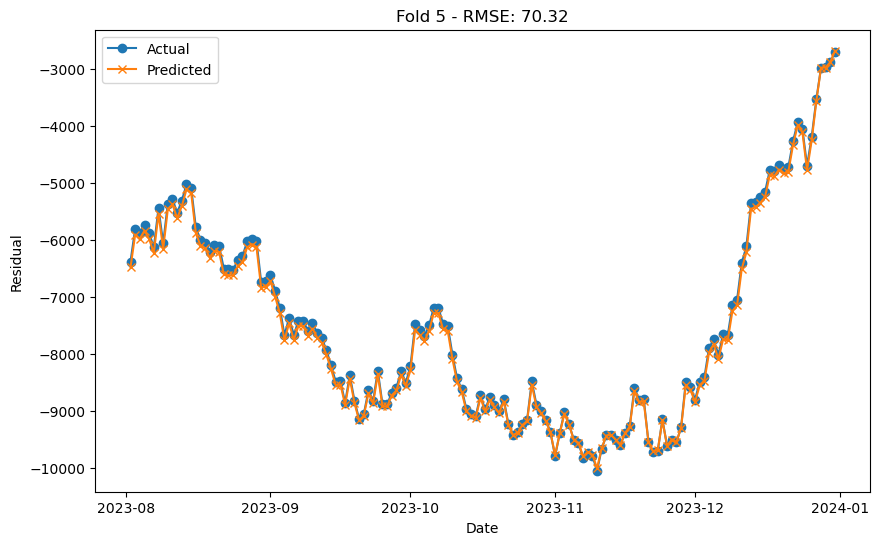

Fold 5 - RMSE: 70.32


In [8]:
#LEARNING RATE: 0,001 dan BATCH SIZE: 32

from sklearn.metrics import mean_squared_error

# Define hyperparameters
learning_rate = 0.001
batch_size = 32
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['Residual_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['Residual_normalized'].values.reshape(-1, 1),
              train_data['Residual_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['Residual_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['Residual'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Tanggal'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Tanggal'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

### Skenario 4

C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


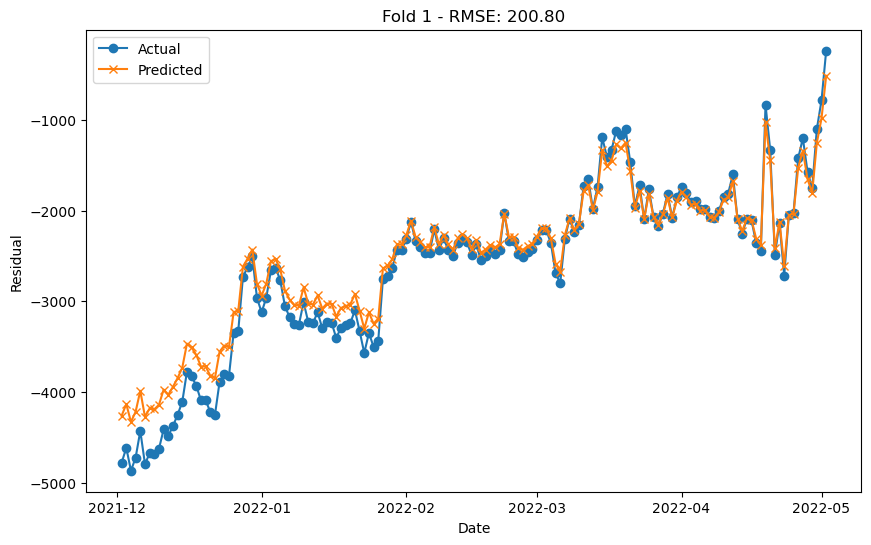

Fold 1 - RMSE: 200.80


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


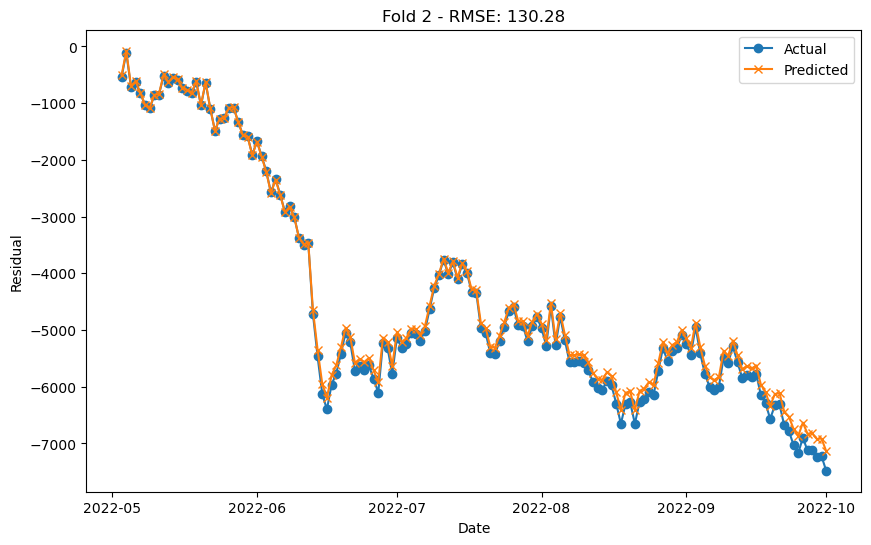

Fold 2 - RMSE: 130.28


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


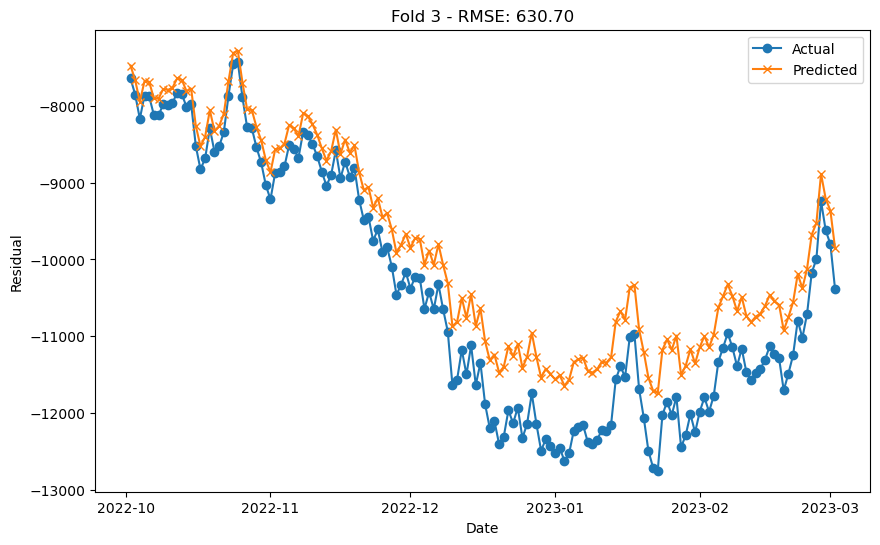

Fold 3 - RMSE: 630.70


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


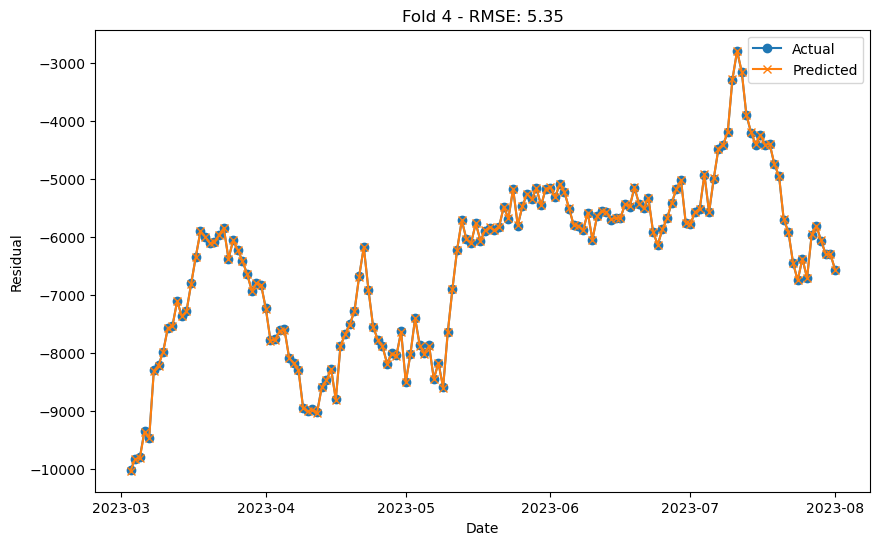

Fold 4 - RMSE: 5.35


C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


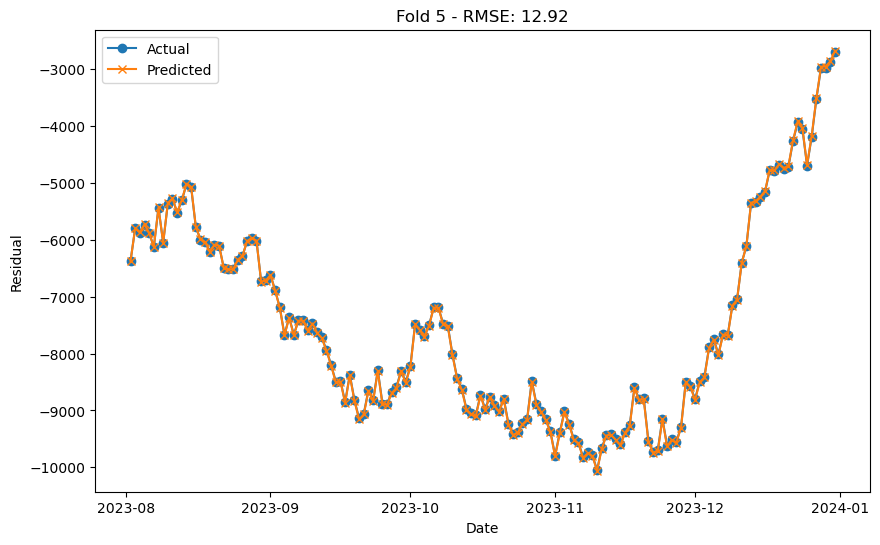

Fold 5 - RMSE: 12.92


In [9]:
#LEARNING RATE: 0,005 dan BATCH SIZE: 32

from sklearn.metrics import mean_squared_error

# Define hyperparameters
learning_rate = 0.005
batch_size = 32
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['Residual_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['Residual_normalized'].values.reshape(-1, 1),
              train_data['Residual_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['Residual_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['Residual'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Tanggal'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Tanggal'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

# Prediksi

C:\Users\akmal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


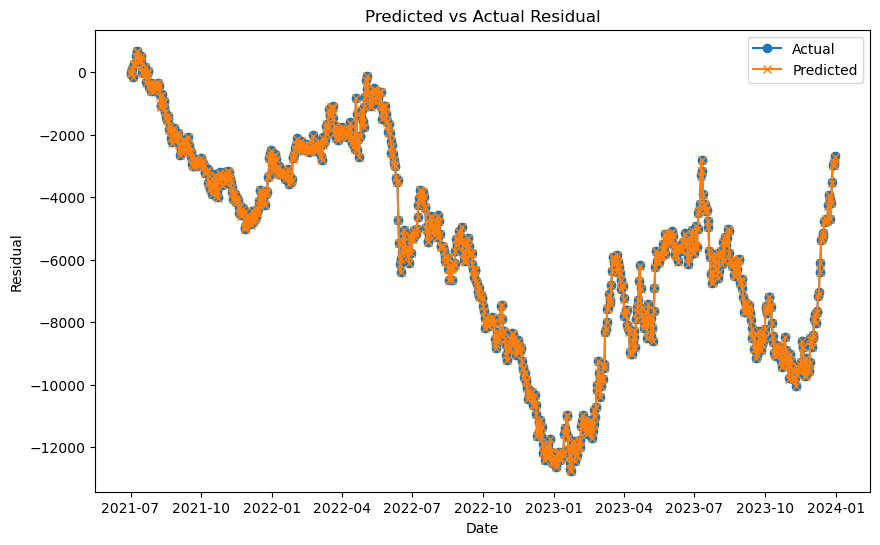

In [10]:
#Prediksi seluruh data

# Import optimizer
from tensorflow.keras.optimizers import Adam

# Define hyperparameters
learning_rate = 0.005
batch_size = 16
epochs = 100
neurons = 40
time_step = 30

# Initialize and compile LSTM model with specified hyperparameters and learning rate
optimizer = Adam(learning_rate=learning_rate)
model = Sequential()
model.add(LSTM(neurons, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train LSTM model
model.fit(data['Residual_normalized'].values.reshape(-1, 1),
          data['Residual_normalized'].values.reshape(-1, 1),
          epochs=epochs, batch_size=batch_size, verbose=0)

# Make predictions for the entire dataset
predictions = model.predict(data['Residual_normalized'].values.reshape(-1, 1))

# Denormalize predictions
denormalized_predictions = scaler.inverse_transform(predictions)

# Plot original data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(data['Tanggal'], data['Residual'], label='Actual', marker='o')
plt.plot(data['Tanggal'], denormalized_predictions, label='Predicted', marker='x')
plt.title("Predicted vs Actual Residual")
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()

In [11]:
denormalized_predictions = pd.DataFrame(denormalized_predictions, columns=['Predictions'])
denormalized_predictions

,Predictions
0,-9.277864
1,-58.815041
2,88.388130
3,-167.197769
4,240.026123
...,...
909,-3529.205811
910,-2978.083008
911,-2976.622803
912,-2884.478027


In [12]:
denormalized_predictions.to_excel("D:/IPB/Skripsi/Data/Prediksi LSTM/predicted_lstm914.xlsx", index=False)